In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [6]:
import sys
sys.path.append('..')

In [35]:
# Mouse Kidney scRNAseq from SurveyGenomics
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8779 × 22105
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'medulla_cortex', 'domain'
    var: 'n_counts', 'n_cells', 'mean', 'std'
    obsm: 'spatial'
    obsp: 'connectivities', 'distances'

In [13]:
import seaborn as sns

In [17]:
out = pd.DataFrame(
    adata.obsm['spatial'], 
    columns=['x', 'y'], 
    index=adata.obs_names
).join(adata.obs[['domain', 'ct2']])

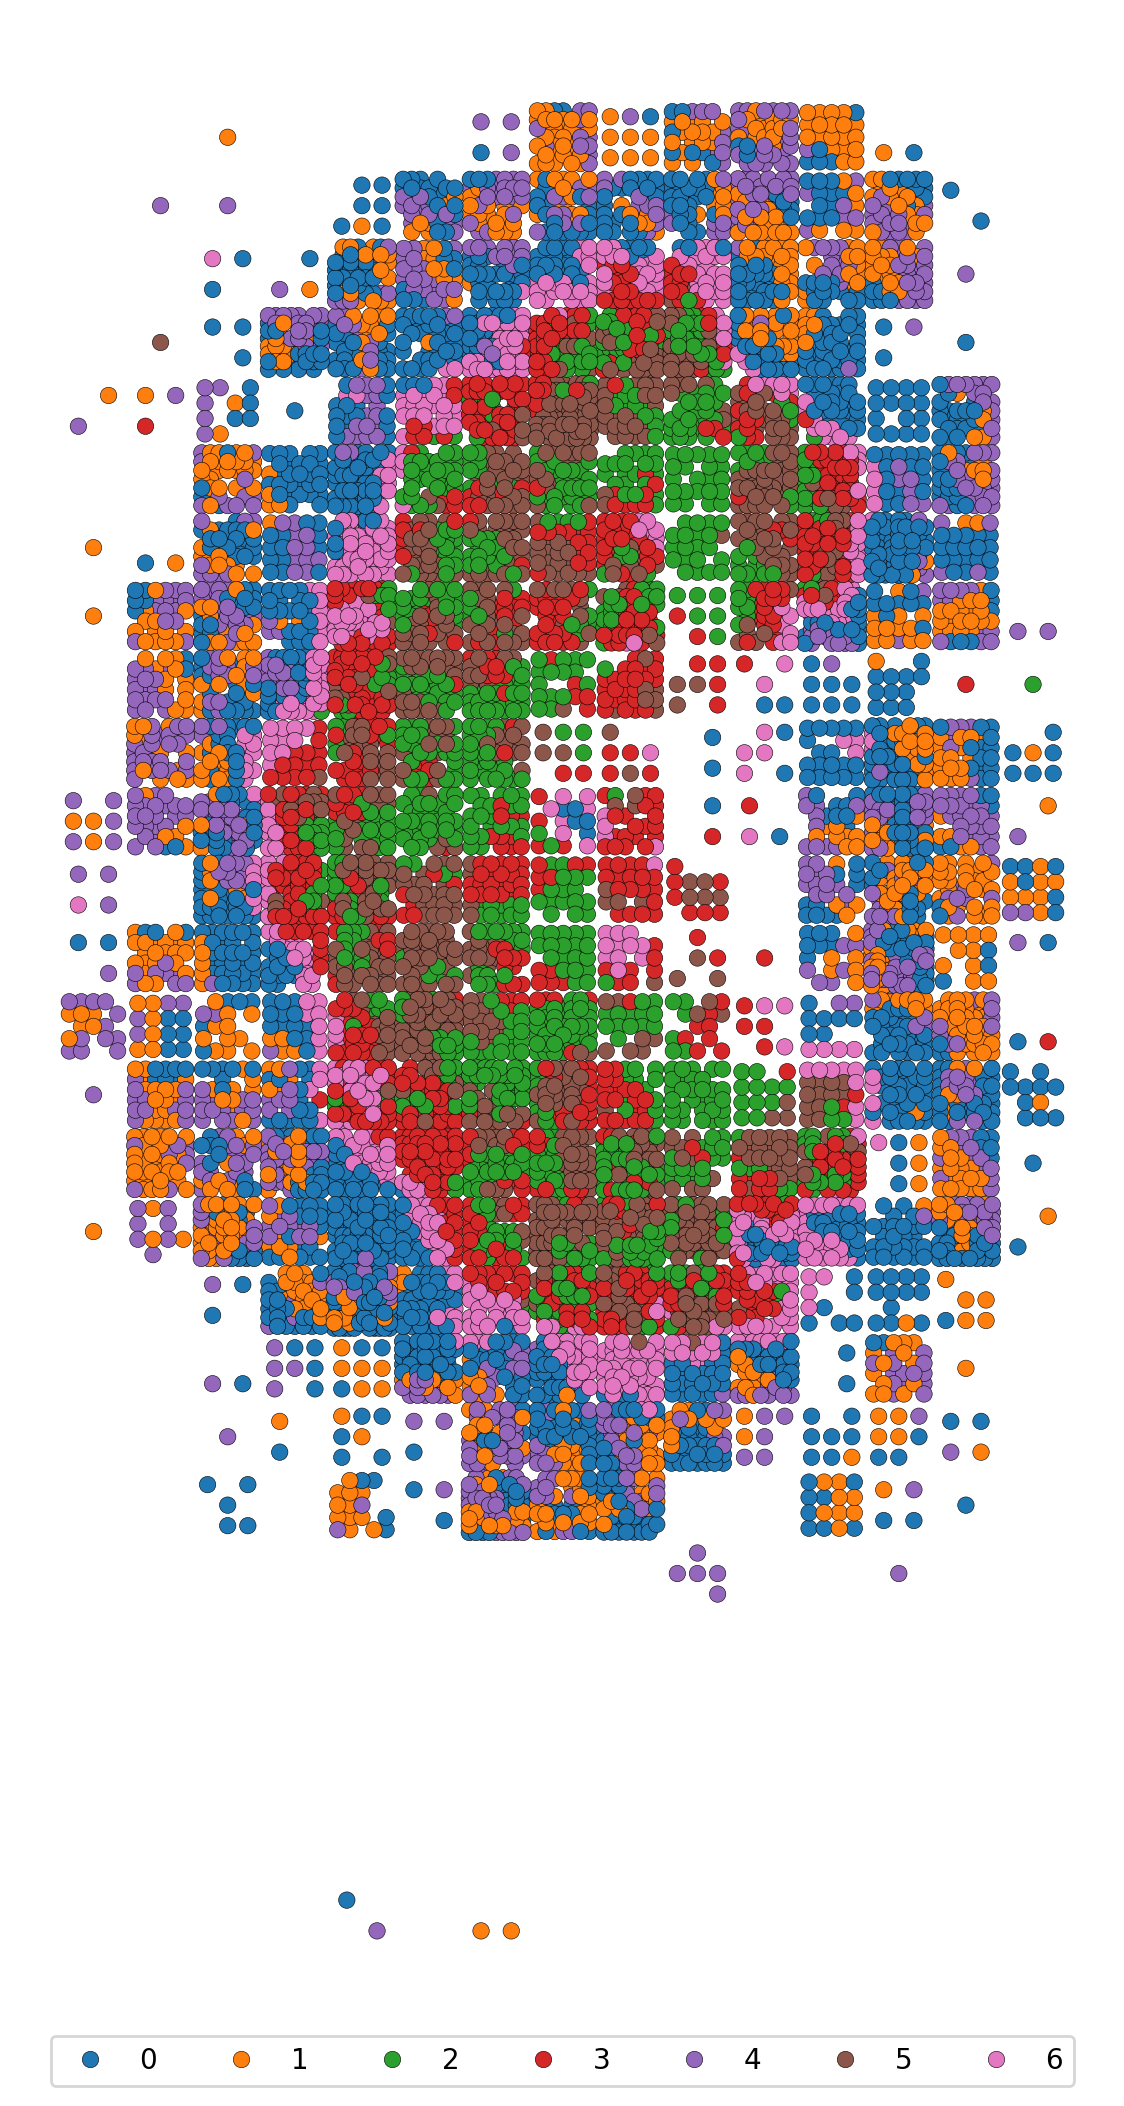

In [22]:
plt.rcParams['figure.figsize'] = (7, 13)
plt.rcParams['figure.dpi'] = 100

sns.scatterplot(
    data=out, x='y', y='x', 
    hue='domain', 
    s=35, marker='o',
    palette='tab10', linewidth=0.2, edgecolor='black'
)
plt.gca().set_axis_off()
plt.legend(ncols=len(out.domain.unique()), bbox_to_anchor=(0.5, 0), loc='upper center')
plt.show()

In [27]:
osmogenes = ['Aqp2', 'Aqp4', 'Cryab', 'Elf5', 'Mal', 'Muc1',
        'Pax2', 'Sgk1', 'Slc14a2', 'Slc5a3']
hypoxia = ['Anxa2', 'Btg1', 'Cdkn1b', 'Ddit3', 'Hexa', 'Hoxb9', 'Hspa5', 'Tes']
markers = ['Wt1', 'Nphs2', 'Sord', 'Cyp2e1', 'Lrp2', 'Bst1', 'Slc4a11', 'Slc12a1', 
        'Umod', 'Slc12a3', 'Calb1', 'Aqp2', 'Aqp4']
nephron = ['Cldn1', 'Spp2', 'Lrp2', 'Aqp1', 'Sptssb', 'Slc12a1', 'Slc12a3', 'Calb1']
collecting_duct = ['Hsd11b2', 'Aqp4', 'Aqp2', 'Atp6v1g3', 'Gata3', 'Calb1']
vascular = ['Kdr', 'Cdh5', 'Vegfa', 'Emcn', 'Podxl']
hema = ['Cd52', 'Fcer1g']
immune = ['Thy1', 'Cd79a', 'Pax5']
stroma = ['Col1a1', 'Meis1', 'Postn']
podocyte = ['Pax8', 'Nphs1', 'Podxl', 'Meis1', 'Aldh1a2']

extra_genes = osmogenes + hypoxia + markers + \
    nephron + collecting_duct + vascular + hema + \
    immune + stroma + podocyte

In [28]:
import os, sys 
sys.path.append('../../src')

In [29]:
import celloracle as co
base_GRN = co.data.load_human_promoter_base_GRN()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [30]:
from spaceoracle.tools.network import expand_paired_interactions
import commot as ct

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type="Secreted Signaling"
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

coms_df =df_ligrec.query('receptor.str.contains("CXCR") or ligand.str.contains("CXCL")')
genes_of_interest = list(np.unique(coms_df.ligand.unique().tolist() + \
                         coms_df.receptor.unique().tolist()))
# len(genes_of_interest)
genes_of_interest = genes_of_interest + list(extra_genes)
len(genes_of_interest)

87

In [31]:
n_top_genes = 3500
min_cells = 50
min_counts = 200

In [36]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]

In [37]:
sc.pp.filter_genes(adata, min_cells=min_cells)
adata.layers["raw_count"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(genes_of_interest))]

adata.layers["normalized_count"] = adata.to_df().values.copy()
adata

AnnData object with n_obs × n_vars = 8779 × 3512
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'medulla_cortex', 'domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'raw_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [39]:
adata.layers["normalized_count"].max()

8.085063

In [44]:
adata.obs['domain'] = adata.obs['domain'].astype('category')
adata.obs['cell_type'] = adata.obs['domain'].copy()

In [45]:
adata.obs['cell_type'].value_counts()

cell_type
0    2110
1    1202
2    1196
3    1190
4    1152
5    1143
6     786
Name: count, dtype: int64

In [46]:
adata.obs['cell_type_int'] = pd.Categorical(adata.obs['cell_type']).codes

In [47]:
from spaceoracle.oracles import SpaceTravLR
from spaceoracle.tools.network import HumanTonsilRegulatoryNetwork
co_grn = HumanTonsilRegulatoryNetwork()

star = SpaceTravLR(
    adata, 
    save_dir='./models',
    annot='cell_type_int',
    grn=co_grn
)

star.adata

Calculating MAGIC...
  Running MAGIC on 8779 cells and 3512 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.24 seconds.
    Calculating affinities...
    Calculated affinities in 3.10 seconds.
  Calculated graph and diffusion operator in 14.54 seconds.
  Calculating imputation...
  Calculated imputation in 0.80 seconds.
Calculated MAGIC in 15.36 seconds.


AnnData object with n_obs × n_vars = 8779 × 3512
    obs: 'cell_type_int'
    obsm: 'spatial'
    layers: 'raw_count', 'normalized_count', 'imputed_count'
    obsp: 'connectivities', 'distances'

In [48]:
star.adata.layers['imputed_count'].shape

(8779, 3512)

In [49]:
adata.layers['imputed_count'] = star.adata.layers['imputed_count'].copy()

In [1]:
adata.write_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')

NameError: name 'adata' is not defined

In [51]:
import scanpy as sc 
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8779 × 3512
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'medulla_cortex', 'domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'cell_type_int'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'